## Tutorial 1b: Training a SVM using QEK

This tutorial demonstrates how to create a classification model using the QEK kernel with a generic database. By the end of this guide, you will know how to:

1. **Define a Generic Graph Dataset**: Specify coordinates for the nodes in the dataset.
2. **Compile a Register and Pulse from Each Graph**: Use these components that are used foe QPU execution.
3. **Launch the Compiled Execution**: Run on either a quantum emulator or a physical QPU.
    - 3.1. Execution on an emulator
    - 3.2. Execution on Pasqals QPU
4. **Extract QEK Features for Machine-Learning**: Utilize the results from the quantum execution to derive relevant features using the `QEK` Kernel.
5. **Train a Machine Learning Model**: Build and train the model using the extracted features.

### Notes

- A [companion notebook](./tutorial%20220-20Machine20Learning20with20QEK.ipynb) demonstrates advanced machine learning methods—including Grid Search—that can be used with the QEK kernel - using a real world molecular dataset.
- If you prefer to work at a higher level without getting into quantum-level details, you might opt for the [high-level notebook](./tutorial%201%20-%20Using%20a%20Quantum%20Device%20to%20Extract%20Machine-Learning%20Features.ipynb), which abstracts these details using a more user-friendly API.

---

## 1) Dataset Preparation

As with any machine learning task, the first step is to load and prepare the data.

### Overview
QEK (Quantum-Enhanced Kernel) can work with various types of graphs. In this tutorial, we will use a generic synthetic graph dataset. The dataset will be generated using the `networkx` library, and we will incorporate features and target values to facilitate a classification task.

### Steps

- **Graph Generation**: We will create a synthetic graph using `networkx` and `torch_geometric` dataset.
- **Assigning Node and Edge Features**: Each node and edge will be assigned relevant features.
- **Target Value Assignment**: The target value for each graph will be based on its density. This value will be used in a classification task.
- **Defining Graph Geometry**
   - A generic grid-like geometry will be assigned.
   - The positions of nodes will be stored in the `pos` variable.
   - Users can define custom positions, ensuring compatibility with the QPU register.

### Customization and Considerations
- Users can modify the node and edge features as needed.
- Custom graph layouts should be carefully designed to maintain compatibility with quantum processing unit (QPU)/mulator registers.

By following these steps, we will prepare a dataset suitable for quantum-enhanced graph machine learning tasks.



In [2]:
import math
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data, Dataset


class SyntheticGridGraphDataset(Dataset):
    def __init__(self, num_graphs=100, nodes_list=[2, 4, 6, 10]):
        """
        Creates a dataset of grid-like synthetic graphs with a controlled number of nodes.

        Args:
            num_graphs (int): Number of graphs to generate.
            nodes_list (int): Number of nodes to be placed in the grid.
        """
        super().__init__()
        self.num_graphs = num_graphs
        self.nodes_list = nodes_list
        self.graphs = []
        for i in range(self.num_graphs):
            for n in self.nodes_list:
                self.graphs.append(self.create_graph(n))

    def create_graph(self, num_nodes) -> Data:
        """Generates a structured grid graph where num_nodes dictate the grid size dynamically."""
        self.num_nodes = num_nodes
        self.node_feat_dim = 2
        self.edge_feat_dim = 2
        # Determine grid size dynamically
        rows = math.floor(math.sqrt(self.num_nodes))
        cols = math.ceil(self.num_nodes / rows)

        # Create a grid graph based on the exact number of nodes
        G = nx.grid_2d_graph(rows, cols)
        mapping = {node: i for i, node in enumerate(G.nodes())}
        G = nx.relabel_nodes(G, mapping)

        # Retain only the first `num_nodes` nodes
        select = self.num_nodes
        selected_nodes = list(G.nodes())[:select]
        subgraph = G.subgraph(selected_nodes)

        # Get edges
        edge_transpose = np.array(list(subgraph.edges)).T
        if edge_transpose.size > 0:
            edge_index = torch.tensor(edge_transpose, dtype=torch.long)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        # Generate structured 2D positions based on the dynamically computed grid
        spacing = 5.0 
        pos_array = np.array([[spacing * (i % cols), spacing * (i // cols)] for i in selected_nodes])
        pos = torch.tensor(pos_array, dtype=torch.float)

        # Node features (random)
        node_features = torch.rand((select, self.node_feat_dim), dtype=torch.float)

        # Edge attributes (random)
        if edge_index.shape[1] > 0:
            edge_attr = torch.rand((edge_index.shape[1], self.edge_feat_dim), dtype=torch.float)  
        else:
            edge_attr = torch.empty((0, self.edge_feat_dim), dtype=torch.float)

        # Graph label (binary classification based on connectivity pattern)
        label = torch.tensor([1 if np.random.rand() > 0.5 else 0], dtype=torch.long)

        return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, pos=pos, y=label)

    def len(self):
        return self.num_graphs * len(self.nodes_list)

    def get(self, idx):
        return self.graphs[idx]


In [3]:
# Create dataset with different number of nodes.
dataset = SyntheticGridGraphDataset(num_graphs=100, nodes_list=[2, 3, 4, 5, 10, 15, 20])

print(f"""Dataset created!
      - Total Graphs: {len(dataset)}
      - Sample Graph: {dataset[0]}
    """)

Dataset created!
      - Total Graphs: 700
      - Sample Graph: Data(x=[2, 2], edge_index=[2, 1], edge_attr=[1, 2], y=[1], pos=[2, 2])
    


#### *Notes on Geometry and Coordinates (`Pos`):*
> This package lets researchers embed _graphs_ on Analog Quantum Devices. To do this we need to give these graphs a geometry (their positions in space) and to confirm that the geometry is compatible with a Quantum Device.

> This package builds upon the [Pulser framework](https://pulser.readthedocs.io/). Our objective, in this notebook, is to _compile_ graphs
into a format understood by our Quantum Devices. Which include, a _Pulser Register_ (the position of qubits) and _Pulser Pulses_ (the laser impulses controlling the evolution of the analog device).

> As the geometry depends on the Quantum Device, we need to specify a device to use. For the time being, we'll use Pulser's `AnalogDevice`, which is
a reasonable default device. We'll show you a bit further how to use another device.


Now we will use the `BaseGraph` from qek_graphs.

In [4]:
from tqdm import tqdm
import pulser as pl
import rdkit
import qek.data.graphs as qek_graphs


graphs_to_compile = []

for i, data in enumerate(tqdm(dataset)):
    graph = qek_graphs.BaseGraph(data=data, device=pl.AnalogDevice, id=i)
    graph.target = data.y.item()
    graphs_to_compile.append(graph)


100%|██████████| 700/700 [00:00<00:00, 883.64it/s] 


## 2) Compile a Register and a Pulse

Once the embedding is found, we compile a Register (the position of atoms on the Quantum Device) and a Pulse (the lasers applied to these atoms).

Note that not all graphs can be embedded on a given device. In this notebook, for the sake of simplicity, we simply discard graphs that cannot be trivially embedded. Future versions of this library may succeed at embedding more graphs.

> The user can also define custom register and pulses using the  [Pulser framework](https://pulser.readthedocs.io/)

In [5]:
from qek.shared.error import CompilationError

compiled = [] 

for graph in tqdm(graphs_to_compile):
    try:
        register = graph.compile_register()
        pulse = graph.compile_pulse()
    except CompilationError:
        # Let's just skip graphs that cannot be computed.
        print("Graph %s cannot be compiled for this device" % (graph.id, ))
        continue
    compiled.append((graph, register, pulse))
print("Compiled %s graphs into registers/pulses" % (len(compiled, )))

100%|██████████| 700/700 [00:20<00:00, 33.76it/s]

Compiled 700 graphs into registers/pulses


Let's take a look at some of these registers and pulses.

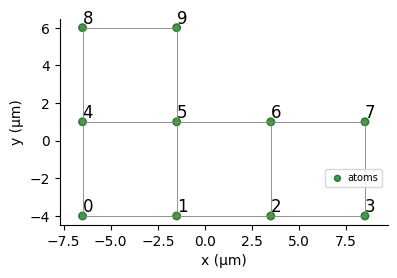

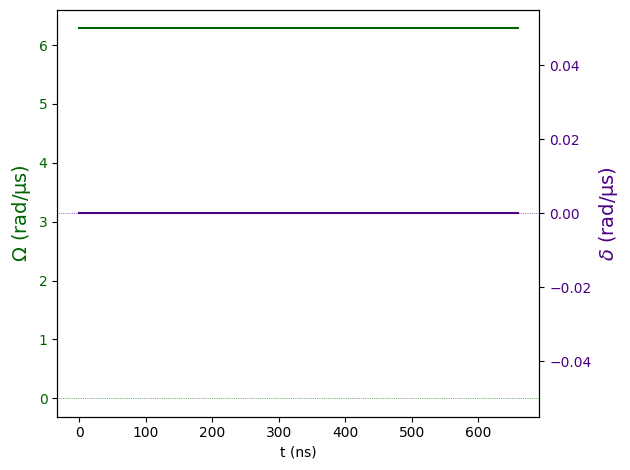

In [6]:
example_graph, example_register, example_pulse = compiled[53]
example_register.draw(blockade_radius=pl.AnalogDevice.min_atom_distance + 0.01)
example_pulse.draw()


## 3) Execution

In this section we will showcase how to execute from register and pulses. This execution will lead to a processed dataset, that we can eventually use to create the QEK Kernel. 
- The results of executing the embedding on the Quantum Device are in field `state_dict`.
- `state_dict` will be used in the `QEK` Kernel in the next steps.

### 3.1) Executing on an emulator

While our objective is to run on a physical QPU, it is generally a good idea to test on an emulator first. For this example, we'll use the QutipEmulator, the simplest emulator provided with Pulser.

> Pasqal has also developed an emulator called emu-mps, which generally provides much better performance and resource usage, so if you hit resource limits, don't hesitate to [check it out](https://github.com/pasqal-io/emulators)!

In [7]:
from qek.data.processed_data import ProcessedData
from qek.backends import QutipBackend

# In this tutorial, to make things faster, we'll only run 5 qubits or less.
# If you wish to run more entries, feel free to increase this value.
#
# # Warning
#
# Emulating a Quantum Device takes exponential amount of resources and time! If you set MAX_QUBITS too
# high, you can bring your computer to its knees and/or crash this notebook.
MAX_QUBITS = 5

processed_dataset = []
executor = QutipBackend(device=pl.AnalogDevice)
for graph, register, pulse in tqdm(compiled):
    if len(register.qubits) > MAX_QUBITS:
        continue
    states = await executor.run(register=register, pulse=pulse)
    processed_dataset.append(ProcessedData.from_register(register=register, pulse=pulse, device=pl.AnalogDevice, state_dict=states, target=graph.target))

100%|██████████| 700/700 [00:38<00:00, 18.18it/s]


### 3.2) Executing on a QPU

Once you have checked that the pulses work on an emulator, you will probably want to move to a QPU. Execution on a QPU takes
resources polynomial in the number of qubits, which hopefully means an almost exponential speedup for large number of qubits.

To experiment with a QPU, you will need either physical access to a QPU, or an account with [PASQAL Cloud](https://docs.pasqal.cloud), which provides you remote access to QPUs built and hosted by Pasqal. In this section, we'll see how to use the latter.

If you don't have an account, just skip to the next section!

> There are other ways to use the SDK. For instance, you can enqueue a job and check later whether it has completed. Also, to work around the long waiting lines, Pasqal provides high-performance distributed and hardware-accelerated emulators, which you can access through the SDK. For more details, [take a look at the documentation of the SDK](https://docs.pasqal.cloud/).

In [8]:
HAVE_PASQAL_ACCOUNT = False # If you have a PASQAL Cloud account, fill in the details and set this to `True`.

if HAVE_PASQAL_ACCOUNT: 
    from qek.backends import RemoteQPUBackend
    processed_dataset = []

    # Initialize connection

    my_project_id = "your_project_id"# Replace this value with your project_id on the PASQAL platform.
    my_username   = "your_username"  # Replace this value with your username or email on the PASQAL platform.
    my_password   = "your_password"  # Replace this value with your password on the PASQAL platform.
        # Security note: In real life, you probably don't want to write your password in the code.
        # See the documentation of PASQAL Cloud for other ways to provide your password.

    # Initialize the cloud client
    executor = RemoteQPUBackend(username=my_username, project_id=my_project_id, password=my_password)

    # Fetch the specification of our QPU
    device = await executor.device()

    # As previously, create the list of graphs and embed them.
    graphs_to_compile = []
    for i, data in enumerate(tqdm(dataset)):
        graph = qek_graphs.PTCFMGraph(data=data, device=device, id=i)
        graphs_to_compile.append(graph)

    compiled = []
    for graph in tqdm(graphs_to_compile):
        try:
            register = graph.compile_register()
            pulse = graph.compile_pulse()
        except CompilationError:
            # Let's just skip graphs that cannot be computed.
            print("Graph %s cannot be compiled for this device" % (graph.id, ))
            continue
    compiled.append((graph, register, pulse))

    # Now that the connection is initialized, we just have to send the work
    # to the QPU and wait for the results.
    for graph, register, pulse in tqdm(compiled):

        # Send the work to the QPU and await the result
        states = await executor.run(register=register, pulse=pulse)
        processed_dataset.append(ProcessedData.from_register(register=register, pulse=pulse, device=device, state_dict=states, target=graph.target))

## A look at the results

Let's take a look at one of our samples:

#### *State Dict*

> This dictionary represents an approximation of the quantum state of the device for this graph after completion of the algorithm.
> - each of the keys represents one possible state for the register (which represents the graph), with each qubit (which represents a single node) being in state `0` or `1`;
> - the corresponding value is the number of samples observed with this specific state of the register.

> Note: Since Quantum Devices are inherently non-deterministic, you will probably obtained different samples if you run this on a Quantum Device instead of loading the dataset.


Total number of samples: 400
        - Example state_dict {'000': 26, '001': 371, '010': 84, '100': 440, '101': 78, '110': 1}


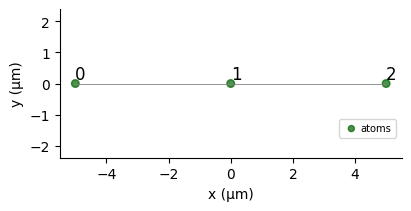

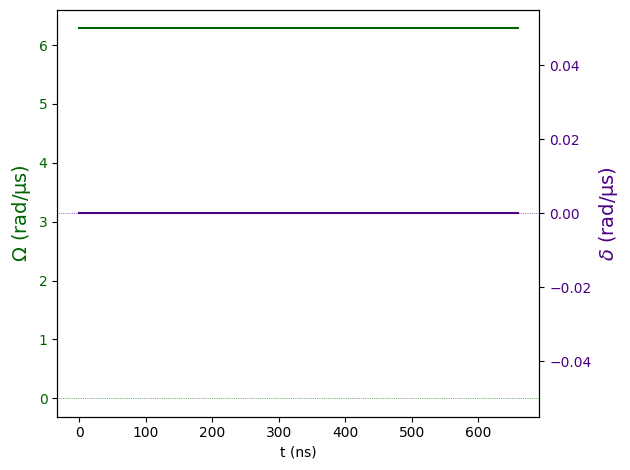

In [9]:
dataset_example: ProcessedData = processed_dataset[53]
print(f"""Total number of samples: {len(processed_dataset)}
        - Example state_dict {dataset_example.state_dict}""")
dataset_example.draw_register()
dataset_example.draw_pulse()
display()


## 4). Extract QEK Features for Machine-Learning

What we have seen so far covers the use of a Quantum Device to extract features. Now we will utilize the execution result to create the QEK Kernel.

### Introduction
This tutorial uses scikit-learn for common machine learning tasks, but the concepts would work with any other machine learning framework as well.
- First we will split the dataset into train and test datasets
- Secondly, we will initialize and `fit` the QEK Kernel.

From the state dictionary, we derive as machine-learning feature the _distribution of excitation_. We'll use this in the next parts to define our kernel.

In [10]:
from sklearn.model_selection import train_test_split

# Prepare features (X) and targets (y)
X = [data for data in processed_dataset]  
y = [data.target for data in processed_dataset] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)
print(f'Size of the training quantum compatible dataset = {len(X_train)}')
print(f'Size of the testing quantum compatible dataset = {len(X_test)}')

Size of the training quantum compatible dataset = 320
Size of the testing quantum compatible dataset = 80


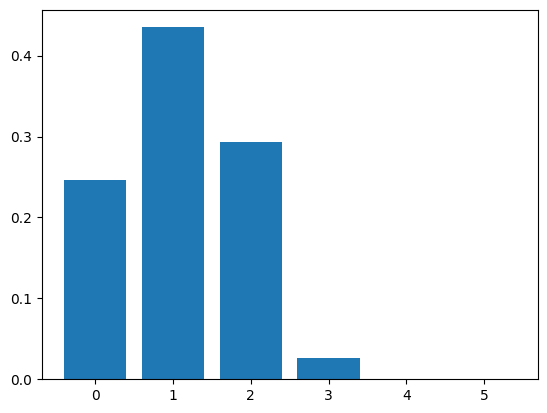

In [11]:
X_train[53].draw_excitation()

The Quantum Evolution Kernel computes a similarity score between two graphs based on quantum-inspired measures. It is designed to work with graph-structured data.

In [12]:
from qek.kernel import QuantumEvolutionKernel as QEK

# Initialize the Quantum Evolution Kernel with a parameter mu
kernel = QEK(mu=0.5)

# Fit
kernel.fit(X_train)

# Transform
K_train = kernel.transform(X_train)
K_test = kernel.transform(X_test)

print(f"Training Kernel Matrix Shape: {K_train.shape}")
print(f"Testing Kernel Matrix Shape: {K_test.shape}")

Training Kernel Matrix Shape: (320, 320)
Testing Kernel Matrix Shape: (80, 320)


## 5) Train a Machine Learning Model

We will use an SVM (Support Vector Machine) to learn how to predict the toxicity of a molecule based on the precomputed kernel. 

In [13]:
from sklearn.svm import SVC

# Define a SVC model with QuantumEvolutionKernel
qek_kernel = QEK(mu=0.5)
model = SVC(kernel=qek_kernel, random_state=42)

### Training

This precomputed kernel will allow us to evaluate the algorithm QEK.

In [14]:
model.fit(X_train, y_train)

SVC(kernel=<qek.kernel.kernel.FastQEK object at 0x70a6ee251e70>,
    random_state=42)

### Evaluation  

We can use the trained model to make predictions on the test dataset

In [15]:
# Making predictions using the trained model and test data
y_pred = model.predict(X_test)

In [16]:
from sklearn.metrics import f1_score, balanced_accuracy_score

print("\nEvaluation Results:")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.2f}")


Evaluation Results:
F1 Score: 0.52
Balanced Accuracy: 0.56


As this was a synthetic dataset with random features, the accuracy is low. The model can also be tuned further, For extra details on a real dataset, please see the  [companion notebook](./tutorial%201%20-%20Using%20a%20Quantum%20Device%20to%20Extract%20Machine-Learning%20Features.ipynb) for advanced ML steps.